We will walkthrough a more complex form of time-series forecasting, which is LSTM. In this notebook, I build the LSTM model for predicting the FPT's stock price

Our goal in this project is to make the model smarter, as the Linear Regression one just use the data from the previous day to predict the next. We need to get rid of that first.

# 1. Import Libraries

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error


# 2. Getting the Data / Preprocess


We use the build-in library which is the `vnstock` API from SSI

In [53]:
import pandas as pd 
import matplotlib.pyplot as plt
from vnstock import Quote


symbol = 'MBB'
start_date = '2019-01-01'
end_date = '2026-01-14'


quote = Quote(symbol=symbol, source='VCI')

df = quote.history(start=start_date, end=end_date, interval='1D')

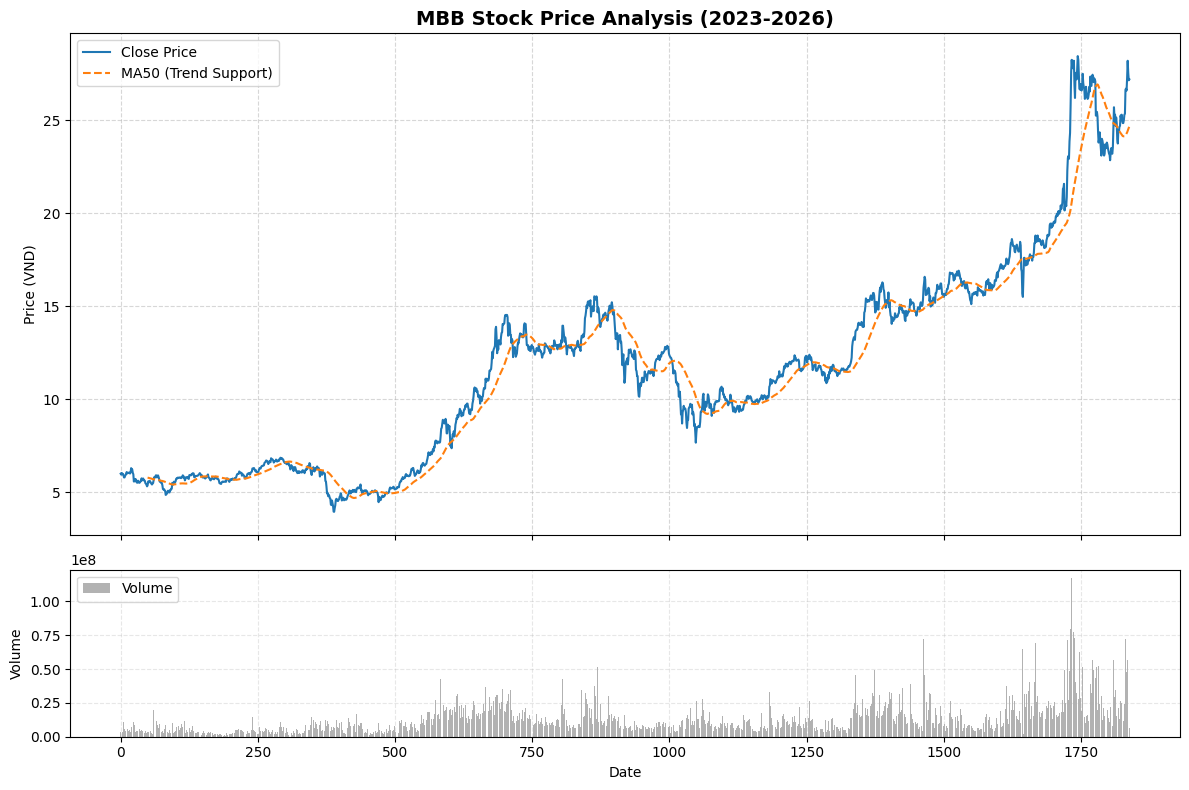

In [54]:
df['MA50'] = df['close'].rolling(window=50).mean()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                               gridspec_kw={'height_ratios': [3, 1]})

# --- Top Chart: Price & MA ---
ax1.set_title('MBB Stock Price Analysis (2023-2026)', fontsize=14, fontweight='bold')
ax1.plot(df.index, df['close'], label='Close Price', color='#1f77b4', linewidth=1.5)
ax1.plot(df.index, df['MA50'], label='MA50 (Trend Support)', color='#ff7f0e', linestyle='--', linewidth=1.5)
ax1.set_ylabel('Price (VND)')
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# --- Bottom Chart: Volume ---
ax2.bar(df.index, df['volume'], label='Volume', color='gray', alpha=0.6)
ax2.set_ylabel('Volume')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, which='both', linestyle='--', alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In order to put our data in the model, we need to preprocess it

Just to remind, this is the thing that we need to predict, the close price:

<Axes: >

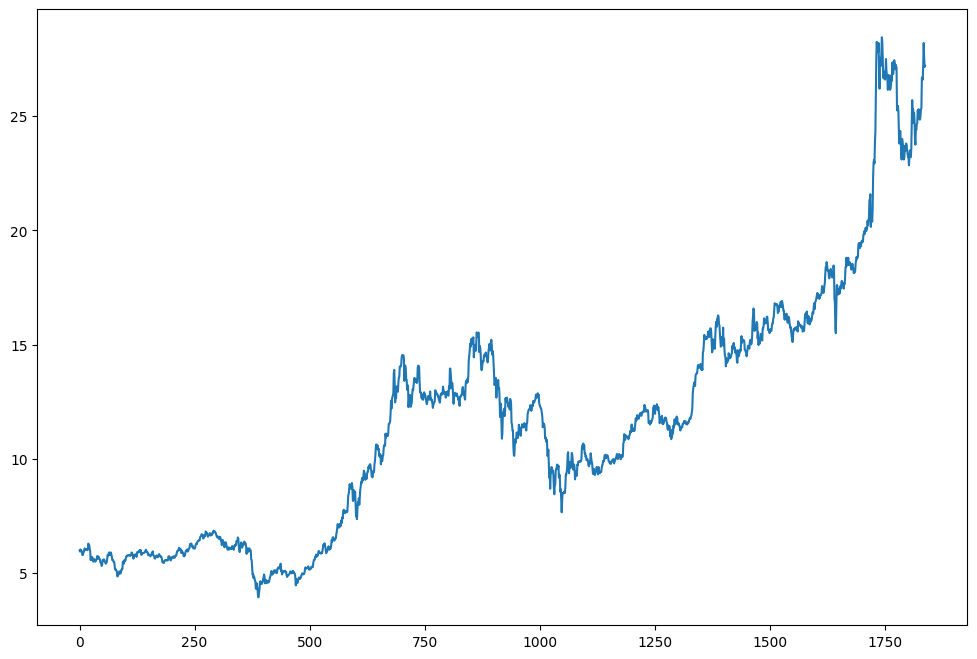

In [55]:
df.close.plot(figsize=(12,8))

In [56]:
# Scale the data using StandardScaler
scaler = StandardScaler()

df['close'] = scaler.fit_transform(pd.DataFrame(df['close']))


In [57]:
df.close

0      -1.029267
1      -1.038433
2      -1.021934
3      -1.034767
4      -1.031100
          ...   
1834    2.877371
1835    3.042363
1836    2.923202
1837    2.849872
1838    2.859039
Name: close, Length: 1839, dtype: float64

The target column is now transformed into data with mean 0 and std 1

Now this is the fun part, we will use a kind of sliding window to get the data for the model. This is widely seen in preprocessing TimeSeries data, and actually if you're sneakpeeking into the LLMs, then it's an usual practice too. They're all **Autoregressive** models if you know it.

In [58]:
feature_columns = ['open', 'high', 'low', 'close', 'volume', 'MA50']
data = df[feature_columns].values

In [59]:
data.shape

(1839, 6)

In [60]:
scaled_data = scaler.fit_transform(data)

In [61]:
def create_multivariate_window(data, n_steps, target_col_idx):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Input (X): All columns for the past 'n_steps' days
        X.append(data[i : i + n_steps, :]) 
        
        # Target (y): Only the 'close' price for the next day
        y.append(data[i + n_steps, target_col_idx])
        
    return np.array(X), np.array(y)

n_steps = 60
# feature_columns = ['open', 'high', 'low', 'close', 'volume', 'MA50']
target_col_idx = 3

X, y = create_multivariate_window(scaled_data, n_steps, target_col_idx)


In [62]:
print(f"Input Shape (X): {X.shape}") 
# Expected: (Samples, 60, 6) -> 6 is the number of features
print(f"Target Shape (y): {y.shape}")

Input Shape (X): (1779, 60, 6)
Target Shape (y): (1779,)


In [63]:
split_ratio = 0.8

split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1423, 60, 6)
y_train shape: (1423,)
X_test shape: (356, 60, 6)
y_test shape: (356,)


So now we're good to train the model !